### Helper Functions

In [ ]:
from toolz import curry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

@curry
def effect(data, y, t, treatment_level):
    # Calculate the difference in mean outcome between the treatment and control group (control is T0 = 0)
    ate = data[data[t] == treatment_level][y].mean() - data[data[t] == 0][y].mean()
    return ate

def cumulative_gain_curve(df, prediction, y, t, treatment_level,
                          ascending=False, normalize=False, steps=100):

    effect_fn = effect(t=t, y=y, treatment_level=treatment_level)
    normalizer = effect_fn(df) if normalize else 0

    size = len(df)
    ordered_df = (df
                  .sort_values(prediction, ascending=ascending)
                  .reset_index(drop=True))

    steps = np.linspace(size/steps, size, steps).round(0)
    effects = [(effect_fn(ordered_df.query(f"index<={int(row)}"))
                - normalizer) * (row/size)
               for row in steps]

    return np.array([0] + effects)

In [ ]:
def get_effects_argmax(effects_arrays, return_matrix=False):
    """Returns argmax for each row of predicted effects for the arbitrary no. of treatments.

    :param effects_arrays: A list of arrays for K treatments, where K>=1 (without control null effects)
    :type effects_arrays: list of np.arrays

    :param return_matrix: Determines if the function returns a matrix of all effects
        (with added null effect for control)
    :type return_matrix: bool

    ...
    :return: A stacked matrix of all effects with added column for control effects (which is always 0)
    :rtype: np.array
    """

    n_rows = effects_arrays[0].shape[0]
    null_effect_array = np.zeros(n_rows)
    stacked = np.stack([null_effect_array] + effects_arrays).T

    if return_matrix:
        return np.argmax(stacked, axis=1), stacked

    return np.argmax(stacked, axis=1)


def get_expected_response(y_true, t_true, effects_argmax):
    """Computes the average expected response for an uplift model according to the formula
        proposed by:
        Zhao, Y., Fang, X., & Simchi-Levi, D. (2017). Uplift Modeling with Multiple Treatments and General Response Types.
        Proceedings of the 2017 SIAM International Conference on Data Mining, 588-596.
        Society for Industrial and Applied Mathematics.
    """

    proba_t = pd.Series(t_true).value_counts() / np.array(t_true).shape[0]
    treatments = proba_t.index.values

    z_vals = 0

    for treatment in treatments:
        h_indicator = effects_argmax == treatment
        t_indicator = t_true == treatment
        t_proba_local = proba_t[treatment]

        z_vals += (1/t_proba_local) * y_true * h_indicator * t_indicator

    return z_vals.mean()

## Library

In [ ]:
# !pip install econml
# !pip install dowhy

from copy import deepcopy
import time

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import dowhy
from dowhy import CausalModel

from econml.metalearners import SLearner, XLearner, TLearner
from econml.dml import LinearDML, CausalForestDML, DML
from econml.dr import DRLearner, SparseLinearDRLearner

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.



## Model Training

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Prep/Colab/hillstrom_cleaned.csv')

# specify treatment, covariate, and outcome variable
hillstrom_X = df.drop(['visit', 'conversion', 'spend', 'treatment'], axis=1)
hillstrom_Y = df['spend']
hillstrom_T = df['treatment']

# Train test split
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
    hillstrom_X,
    hillstrom_Y,
    hillstrom_T,
    test_size=.4
)

In [ ]:
# define a few base models
def create_model(model_type, n_estimators=100, max_depth=8, learning_rate=.01):
    if model_type == 'lgb_reg':
        return LGBMRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate)
    if model_type == 'lgb_cls':
        return LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate)
    if model_type == 'log_reg': # propensity score estimation
        return LogisticRegression(max_iter=1000)
    if model_type == 'gb_reg':
        return GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)
    if model_type == 'gb_cls':
        return GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth)
    else:
        raise NotImplementedError(f'Model type `{model_type}` not implemented.')

Note: LGBM classifier natively handles categorical data in a way that improve the results over one-hot-encoded features in certain cases.

In [ ]:
# instantiate meta-learners using EconML

s_learner = SLearner(
    overall_model=create_model('lgb_reg')
)

t_learner = TLearner(
    models=[
        create_model('lgb_reg'),
        create_model('lgb_reg'),
        create_model('lgb_reg')
    ]
)

x_learner = XLearner(
    models =[
        create_model('lgb_reg'),
        create_model('lgb_reg'),
        create_model('lgb_reg')
    ],
    cate_models=[
        create_model('lgb_reg'),
        create_model('lgb_reg'),
        create_model('lgb_reg')
    ]
)

dml = LinearDML(
    model_y=create_model('lgb_reg'),
    model_t=create_model('lgb_cls'),
    discrete_treatment=True,
    cv=5
)


dr = DRLearner(
    model_propensity = create_model('log_reg'),
    model_regression = create_model('lgb_reg'),
    model_final = create_model('lgb_reg'),
    cv=5
)

cf = CausalForestDML(
    model_y = create_model('lgb_reg'),
    model_t = create_model('lgb_cls'),
    discrete_treatment=True,
    cv=5
)


In [ ]:
# Models
models = {
    'SLearner': s_learner,
    'TLearner': t_learner,
    'XLearner': x_learner,
    'DRLearner': dr,
    'LinearDML': dml,
    'CausalForestDML': cf
}

In [ ]:
# fit the estimators

for model_name, model in models.items():
    print(f'Fitting {model_name}')
    model.fit(
        Y=y_train,
        T=T_train,
        X=X_train,
    )
    print(f'{model_name} done')

Fitting SLearner
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 38400, number of used features: 12
[LightGBM] [Info] Start training from score 1.040753
SLearner done
Fitting TLearner
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 12792, number of used features: 9
[LightGBM] [Info] Start training from score 0.553920
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to re

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


XLearner done
Fitting DRLearner
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 30720, number of used features: 11
[LightGBM] [Info] Start training from score 1.049372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 30720, number of used features: 11
[LightGBM] [Info] Start training from score 1.045534
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhe

In [ ]:
# compute effects for both treatment level
effects_train = {
    'treatment_1': {},
    'treatment_2': {}
}

effects_test = {
    'treatment_1': {},
    'treatment_2': {}
}

for treatment in [1, 2]:
  for model_name, model in tqdm(models.items()):

    # compute effects on train as compared to the control group
    effects_train_pred = models[model_name].effect(X_train.values, T0=0, T1=treatment)
    effects_train[f'treatment_{treatment}'][model_name] = effects_train_pred

    effects_test_pred = models[model_name].effect(X_test.values, T0=0, T1=treatment)
    effects_test[f'treatment_{treatment}'][model_name] = effects_test_pred

100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


## Model Evaluation

### 1. Plot uplift Curve

In [ ]:
import pandas as pd

# Define a function to create the prediction DataFrame
def create_preds_df(y, T, effects_dict, y_name='y', T_name='T'):
    # Initialize the DataFrame with y and T values
    preds_res = pd.DataFrame({
        y_name: y,
        T_name: T
    })

    # Iterate over treatments and models to extract predictions and add them to the DataFrame
    for treatment, models_dict in effects_dict.items():
        for model_name, predictions in models_dict.items():
            # Create a column name based on the model and treatment
            column_name = f'{model_name}_{treatment}'

            # Add the predictions to the DataFrame
            preds_res[column_name] = predictions

    return preds_res

# Create train and test prediction DataFrames using the function
train_preds_res = create_preds_df(y_train, T_train, effects_train, y_name='y_train', T_name='T_train')
test_preds_res = create_preds_df(y_test, T_test, effects_test, y_name='y_test', T_name='T_test')

In [ ]:
def plot_uplift_curve(df, y_col, t_col, treatments, treatment_levels, normalized=False):
    # Create subplots for the two treatment levels
    fig, axes = plt.subplots(1, len(treatment_levels), figsize=(12, 6), sharey=True)

    # If there's only one axis, wrap it into a list (for consistency)
    if len(treatment_levels) == 1:
        axes = [axes]

    # Iterate over treatment levels and corresponding axes
    for ax, treatment_level in zip(axes, treatment_levels):
        treatment = treatments[treatment_level - 1]  # Assumes treatments are 1-based index

        # Filter columns for this treatment level
        model_cols = [col for col in df.columns if f'treatment_{treatment_level}' in col]

        # Loop through filtered models and plot the cumulative gain curve for each
        for m in model_cols:
            cum_gain = cumulative_gain_curve(df, m, y_col, t_col, treatment_level=treatment_level, normalize=normalized)
            x = np.array(range(len(cum_gain)))
            ax.plot(100 * (x / x.max()), cum_gain, label=m)

        # Add the random model as a baseline
        ax.plot([0, 100], [0, effect(df, y_col, t_col, treatment_level=treatment_level)], linestyle="--", label="Random Model", color="black")

        # Set plot labels and title for each axis
        ax.set_xlabel("Top %")
        ax.set_ylabel("Cumulative Gain")
        ax.set_title(f"Cumulative Gain Curve for Treatment {treatment_level} (Normalized={normalized})", fontsize=10)
        ax.legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


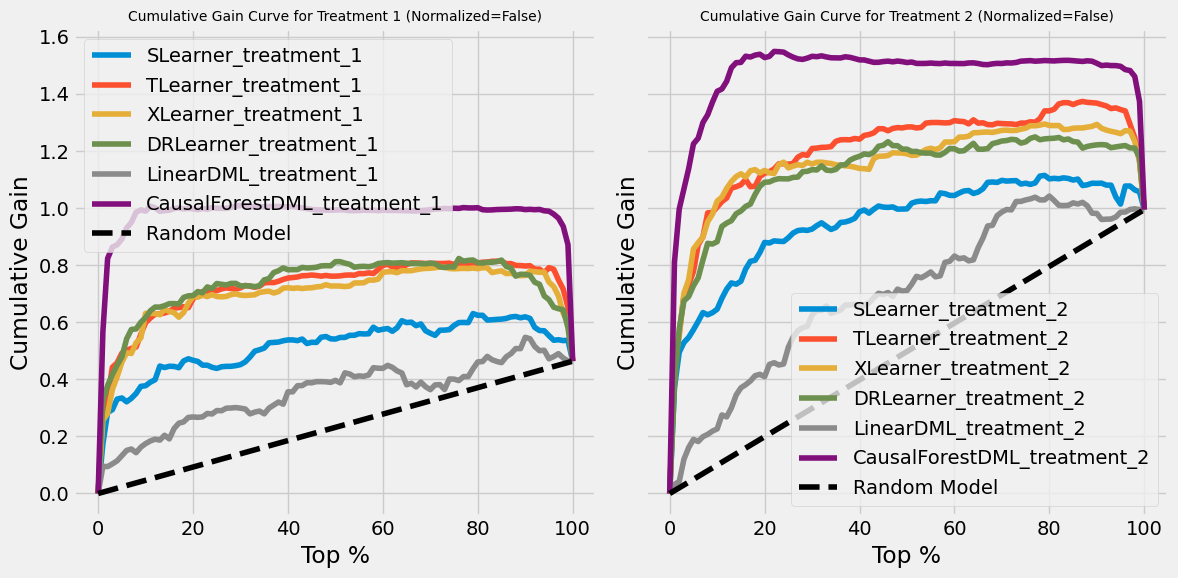

In [ ]:
plot_uplift_curve(train_preds_res, 'y_train', 'T_train', ['treatment_1', 'treatment_2'], [1, 2])

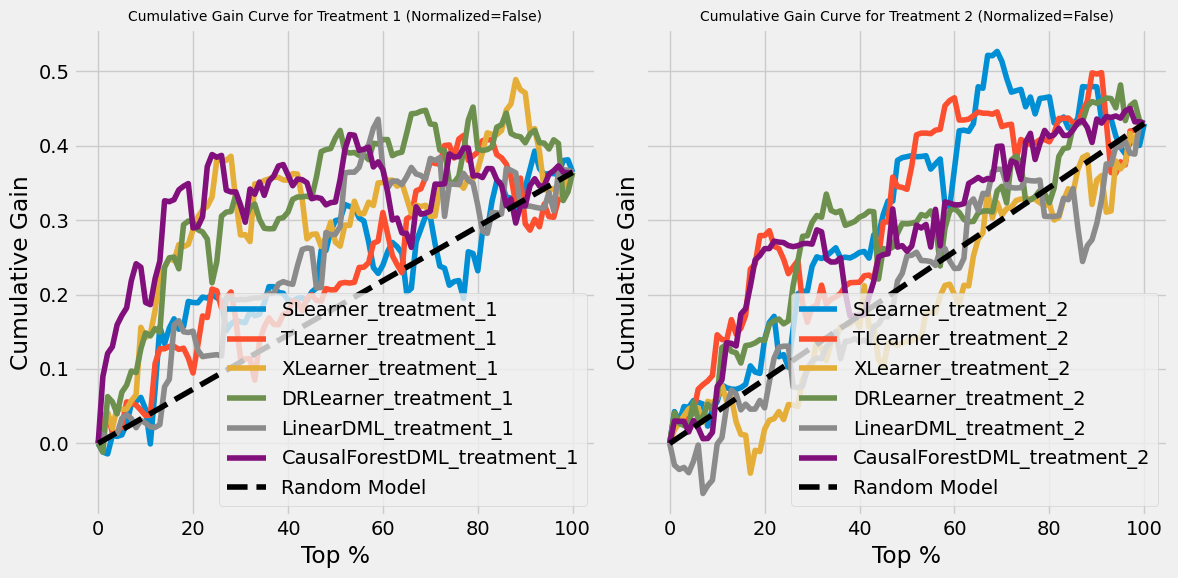

In [ ]:
plot_uplift_curve(test_preds_res, 'y_test', 'T_test', ['treatment_1', 'treatment_2'], [1, 2])

### 2. Obtain Expected Response

In [ ]:
# Compute expected response
print('Expecetd response on train:\n')
for model_name in models:
    effects_argmax = get_effects_argmax(
        [
            effects_train['treatment_1'][model_name],
            effects_train['treatment_2'][model_name]
        ]
    )

    expected_response = get_expected_response(
        y_true=y_train,
        t_true=T_train,
        effects_argmax=effects_argmax
    )

    print(f'{model_name}: {expected_response}')

print('\n' + '-'*30)

print('Expected response on test:\n')
for model_name in models:
    effects_argmax = get_effects_argmax(
        [
            effects_test['treatment_1'][model_name],
            effects_test['treatment_2'][model_name]
        ]
    )

    expected_response = get_expected_response(
        y_true=y_test,
        t_true=T_test,
        effects_argmax=effects_argmax
    )

    print(f'{model_name}: {expected_response}')

Expecetd response on train:

SLearner: 1.862701954698977
TLearner: 2.4617713162878947
XLearner: 2.2942939275438805
DRLearner: 2.2546291340177778
LinearDML: 1.6052226449796319
CausalForestDML: 3.023891138264551

------------------------------
Expected response on test:

SLearner: 1.3428999106197088
TLearner: 1.2581172342195663
XLearner: 1.418989412721014
DRLearner: 1.3455204086521857
LinearDML: 1.2887633146034492
CausalForestDML: 1.4570483001789925


From both metrics, CausalForestDML performs the best on the test dataset. We will go with CausalForestDML's estimation and perform sensitivity analysis.

## What does the result tells us?

In [ ]:
# let us first obtain the confidence interval

models['CausalForestDML'].effect_interval(X=X_test, T0=0, T1=1)

(array([-1.32269905, -0.04351242, -0.0381547 , ..., -0.11775033,
        -0.95217163, -1.66876363]),
 array([1.09078197, 0.22413725, 0.02478691, ..., 0.14858213, 1.8011827 ,
        5.68261592]))

In [ ]:
models['CausalForestDML'].feature_importances_

array([0.13449447, 0.69205433, 0.02284883, 0.01842353, 0.03758979,
       0.03689674, 0.02243676, 0.02551391, 0.00974164])

In [ ]:
cf_bootstrap = CausalForestDML(
    model_y = create_model('lgb_reg'),
    model_t = create_model('lgb_cls'),
    discrete_treatment=True,
    cv=5,
    inference='bootstrap'
)

cf_bootstrap.fit(
    Y=y_train,
    T=T_train,
    X=X_train,
)

effects_test_bootstrap = {
    'treatment_1': {},
    'treatment_2': {}
}

for treatment in [1, 2]:
  effects_test_pred_bootstrap = cf_bootstrap.effect(X_test.values, T0=0, T1=treatment)
  effects_test_bootstrap[f'treatment_{treatment}']['CausalForestDML_bootstrap'] = effects_test_pred_bootstrap


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 30720, number of used features: 9
[LightGBM] [Info] Start training from score -1.099296
[LightGBM] [Info] Start training from score -1.101448
[LightGBM] [Info] Start training from score -1.095103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 30720, number of used features: 9
[LightGBM] [Info] Start training from score 1.023547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047324 seconds.
You can set `force_col_wise=true` to remove

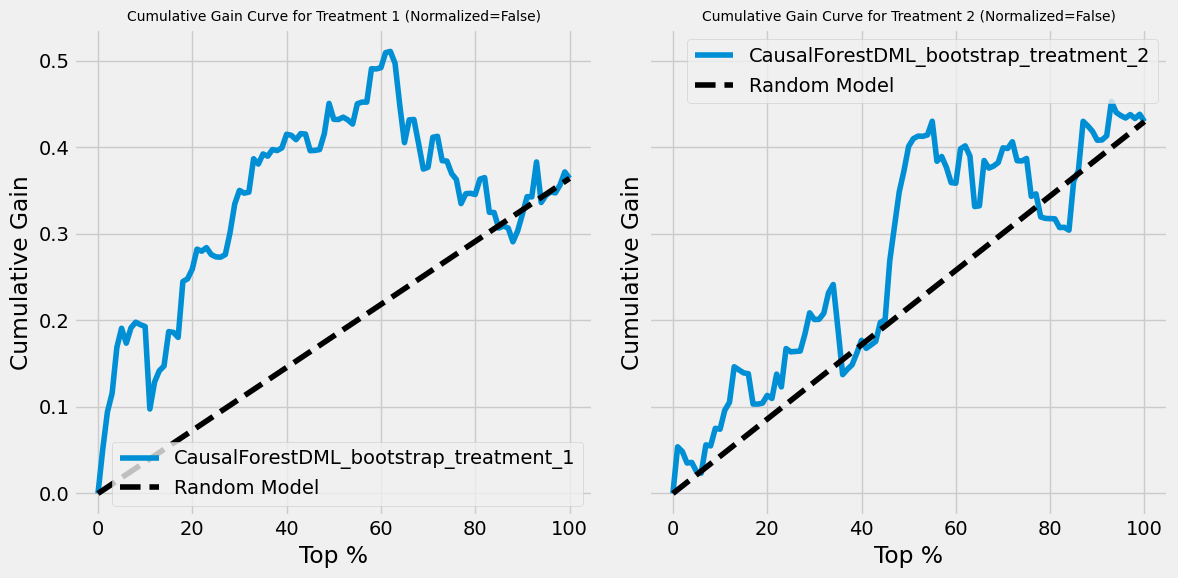

In [ ]:
test_preds_res_bootstrap = create_preds_df(y_test, T_test, effects_test_bootstrap, y_name='y_test', T_name='T_test')
plot_uplift_curve(test_preds_res_bootstrap, 'y_test', 'T_test', ['treatment_1', 'treatment_2'], [1, 2])

In [ ]:
# Confidence interval for treatment = 1
confidence_interval_treatment_1 = models['CausalForestDML'].effect_interval(X=X_test, T0=0, T1=1)
print("Confidence interval for treatment = 1:", confidence_interval_treatment_1)

# Confidence interval for treatment = 2
confidence_interval_treatment_2 = models['CausalForestDML'].effect_interval(X=X_test, T0=0, T1=2)
print("Confidence interval for treatment = 2:", confidence_interval_treatment_2)

Confidence interval for treatment = 1: (array([-1.32269905, -0.04351242, -0.0381547 , ..., -0.11775033,
       -0.95217163, -1.66876363]), array([1.09078197, 0.22413725, 0.02478691, ..., 0.14858213, 1.8011827 ,
       5.68261592]))
Confidence interval for treatment = 2: (array([-8.80501864, -2.96425091, -0.03843266, ..., -3.09078929,
       -0.30537107, -1.72035075]), array([13.11614354,  4.66192062,  0.04652237, ...,  7.31935679,
        0.50496298,  2.70611255]))


In [ ]:
best_model_pred =pd.DataFrame({
    'treatment': T_test,
    'spend': y_test
})

# append cf_bootstrap's preds and CI to the df
for treatment in [1, 2]:
  best_model_pred[f'cf_bootstrap_treatment_{treatment}'] = effects_test_bootstrap[f'treatment_{treatment}']['CausalForestDML_bootstrap']


In [ ]:
# append the confidence interval lower and upper bound to the df
for treatment in [1, 2]:
  best_model_pred[f'cf_bootstrap_treatment_{treatment}_lower'] = confidence_interval_treatment_1[0]
  best_model_pred[f'cf_bootstrap_treatment_{treatment}_upper'] = confidence_interval_treatment_1[1]

  best_model_pred[f'cf_bootstrap_treatment_{treatment}_lower'] = confidence_interval_treatment_2[0]
  best_model_pred[f'cf_bootstrap_treatment_{treatment}_upper'] = confidence_interval_treatment_2[1]


In [ ]:
best_model_pred.head()

,treatment,spend,cf_bootstrap_treatment_1,cf_bootstrap_treatment_2,cf_bootstrap_treatment_1_lower,cf_bootstrap_treatment_1_upper,cf_bootstrap_treatment_2_lower,cf_bootstrap_treatment_2_upper
18963,0,0.0,-0.529738,3.362090,-8.805019,13.116144,-8.805019,13.116144
21952,2,0.0,-0.268079,0.270709,-2.964251,4.661921,-2.964251,4.661921
2565,2,0.0,0.016299,-0.000990,-0.038433,0.046522,-0.038433,0.046522
24120,1,0.0,0.220761,0.003177,-0.192980,0.254604,-0.192980,0.254604
55559,2,0.0,-0.418990,-1.103497,-1.461436,0.716716,-1.461436,0.716716


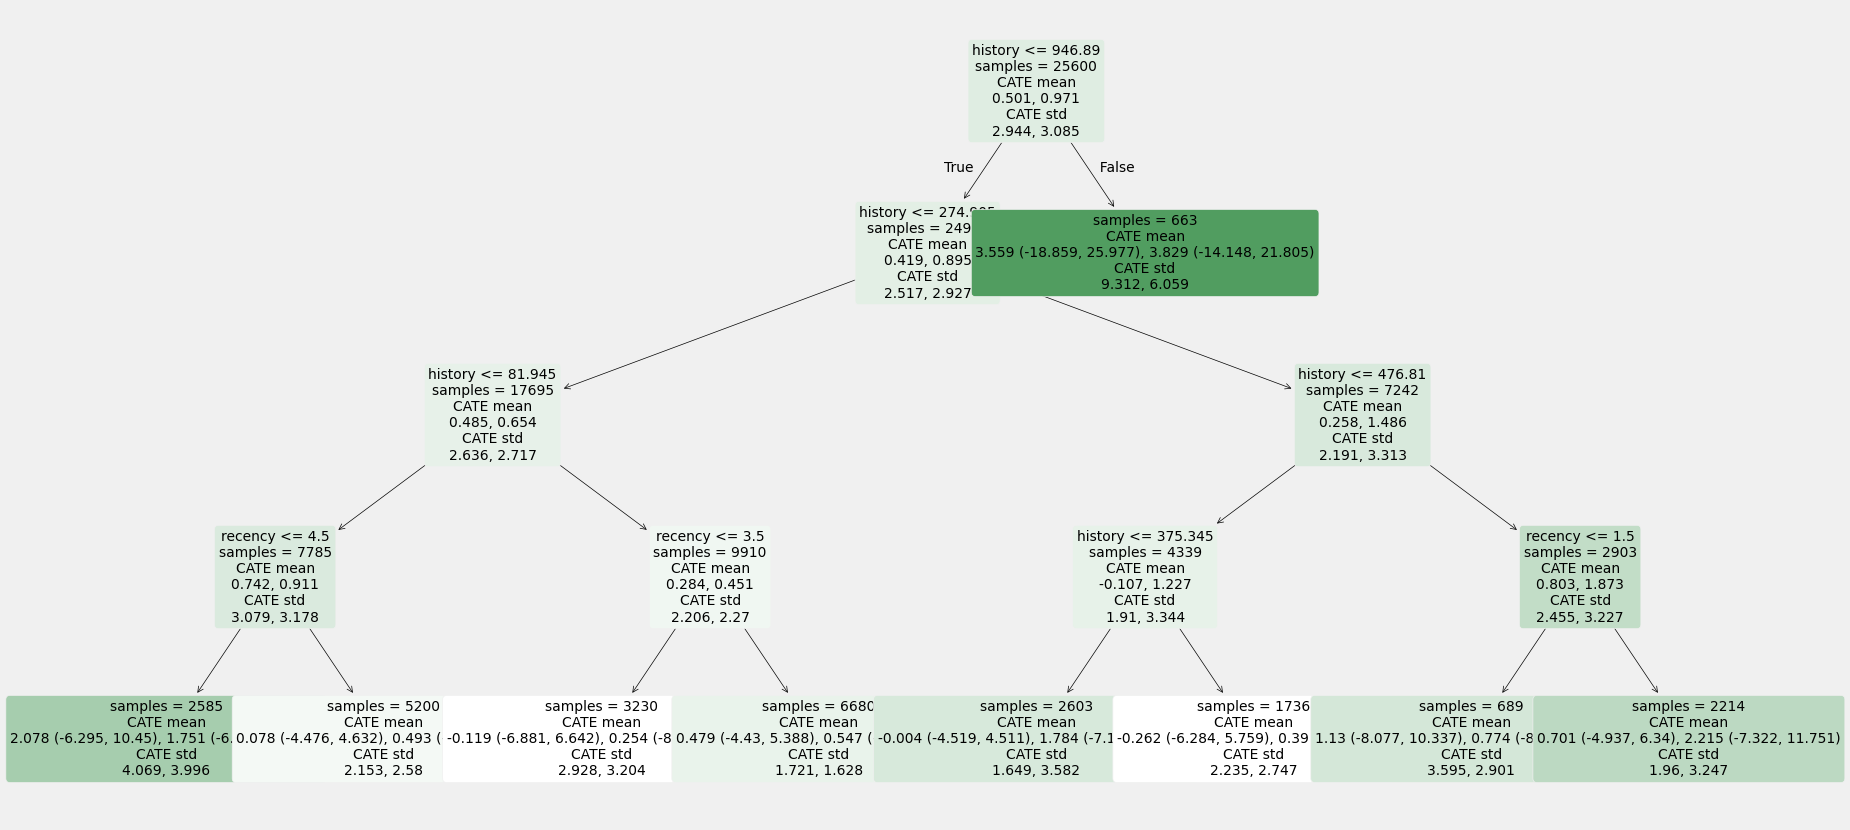

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter

intrp = SingleTreeCateInterpreter(
    include_model_uncertainty=True,
    max_depth=4,
    min_samples_leaf=500
)

intrp.interpret(cf_bootstrap, X_test)

plt.figure(figsize=(20, 10))
intrp.plot(feature_names=X_test.columns, fontsize=10)

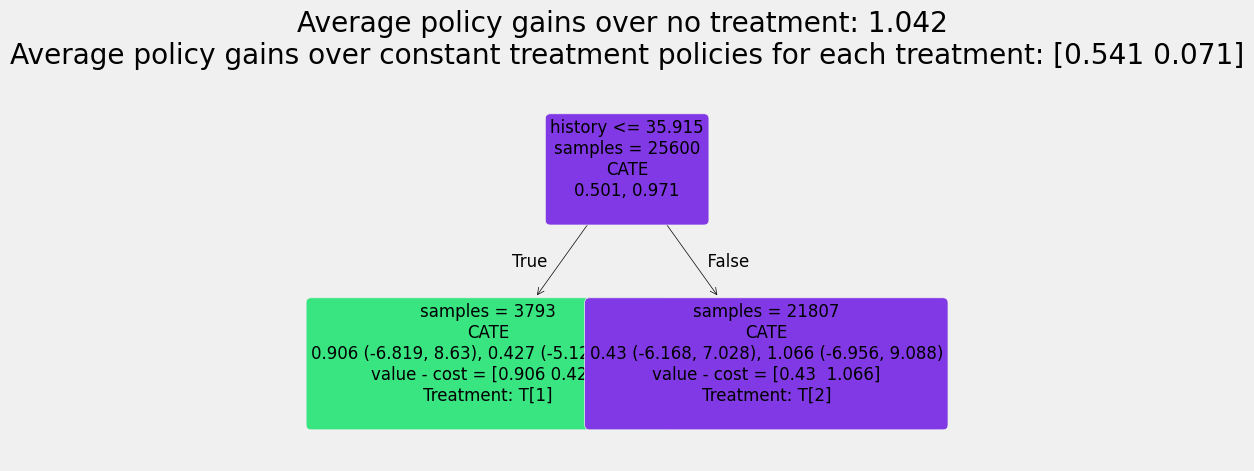

In [ ]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

intrp = SingleTreePolicyInterpreter(
    include_model_uncertainty=True,
    risk_level=None,
    max_depth=4,
    min_samples_leaf=1,
    min_impurity_decrease=.001,
    risk_seeking=True
)

intrp.interpret(cf_bootstrap, X_test)
intrp.plot(feature_names=X_test.columns, fontsize=12)

# Estimate Robustnes Check

In [ ]:
T_train_shuffled = np.random.permutation(T_train.values)

# Fit the model with the shuffled treatment assignments
cf_bootstrap.fit(Y=y_train, T=T_train_shuffled, X=X_train)

# Check the causal effect with randomized treatment
placebo_effects = cf_bootstrap.effect(X_test.values)
print("Placebo effect estimates:", placebo_effects)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 30720, number of used features: 9
[LightGBM] [Info] Start training from score -1.099296
[LightGBM] [Info] Start training from score -1.101448
[LightGBM] [Info] Start training from score -1.095103
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 30720, number of used features: 9
[LightGBM] [Info] Start training from score 1.064597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019860 seconds.
You can set `force_row_wise=true` to remove

In [ ]:
mean_placebo_effect = np.mean(placebo_effects)
std_placebo_effect = np.std(placebo_effects)

print(f"Mean of placebo effect estimates: {mean_placebo_effect}")
print(f"Standard deviation of placebo effect estimates: {std_placebo_effect}")

Mean of placebo effect estimates: -0.21245589923170263
Standard deviation of placebo effect estimates: 3.2177060549110155


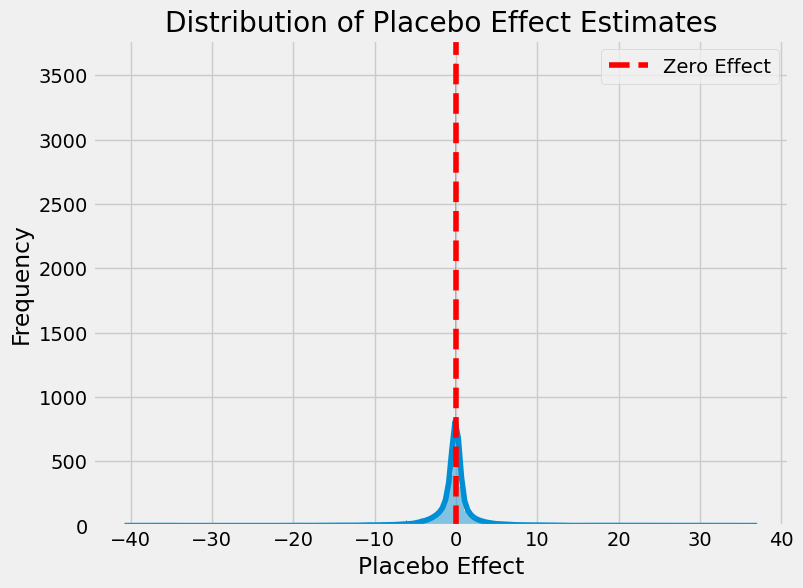

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a histogram of the placebo effect estimates
plt.figure(figsize=(8,6))
sns.histplot(placebo_effects, kde=True)
plt.title("Distribution of Placebo Effect Estimates")
plt.xlabel("Placebo Effect")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--', label='Zero Effect')
plt.legend()
plt.show()
